<a href="https://colab.research.google.com/github/SergioDLezama/Retail-Analysis/blob/main/Predict_Customer_Segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/SergioDLezama/Retail-Analysis

fatal: destination path 'Retail-Analysis' already exists and is not an empty directory.


In [3]:
#!pip install scikeras

In [4]:
!pip install keras-tuner

In [5]:
# Importing necesaries libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, recall_score

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from keras_tuner import RandomSearch
from tensorflow.keras import backend

import warnings
warnings.filterwarnings("ignore")

<ipython-input-5-26595537f354>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [6]:
pd.set_option('display.max_columns', None)

In [7]:
sns.set_style("whitegrid")

In [8]:
sns.set_palette('Blues_r')

In [9]:
df = pd.read_csv('/content/Retail-Analysis/retail_data.csv')

In [10]:
data = df.copy()

In [11]:
df.head(3)

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,21.0,Male,Low,Regular,9/18/2023,2023.0,September,22:03:55,3.0,108.028757,324.086270,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts
1,2174773.0,69749.0,Kelsey Hill,Mark36@gmail.com,6.852900e+09,82072 Dawn Centers,Nottingham,England,99071.0,UK,19.0,Female,Low,Premium,12/31/2023,2023.0,December,8:42:04,2.0,403.353907,806.707815,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.0,Lenovo Tab
2,6679610.0,30192.0,Scott Jensen,Shane85@gmail.com,8.362160e+09,4133 Young Canyon,Geelong,New South Wales,75929.0,Australia,48.0,Male,Low,Regular,4/26/2023,2023.0,April,4:06:29,3.0,354.477600,1063.432799,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.0,Sports equipment


In [12]:
df.shape

(302010, 30)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302010 entries, 0 to 302009
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    301677 non-null  float64
 1   Customer_ID       301702 non-null  float64
 2   Name              301628 non-null  object 
 3   Email             301663 non-null  object 
 4   Phone             301648 non-null  float64
 5   Address           301695 non-null  object 
 6   City              301762 non-null  object 
 7   State             301729 non-null  object 
 8   Zipcode           301670 non-null  float64
 9   Country           301739 non-null  object 
 10  Age               301837 non-null  float64
 11  Gender            301693 non-null  object 
 12  Income            301720 non-null  object 
 13  Customer_Segment  301795 non-null  object 
 14  Date              301651 non-null  object 
 15  Year              301660 non-null  float64
 16  Month             30

## Data treatment

In [14]:
df.isnull().sum()

Transaction_ID      333
Customer_ID         308
Name                382
Email               347
Phone               362
Address             315
City                248
State               281
Zipcode             340
Country             271
Age                 173
Gender              317
Income              290
Customer_Segment    215
Date                359
Year                350
Month               273
Time                350
Total_Purchases     361
Amount              357
Total_Amount        350
Product_Category    283
Product_Brand       281
Product_Type          0
Feedback            184
Shipping_Method     337
Payment_Method      297
Order_Status        235
Ratings             184
products              0
dtype: int64

In [15]:
df = df.dropna()

In [16]:
df.isnull().sum()

Transaction_ID      0
Customer_ID         0
Name                0
Email               0
Phone               0
Address             0
City                0
State               0
Zipcode             0
Country             0
Age                 0
Gender              0
Income              0
Customer_Segment    0
Date                0
Year                0
Month               0
Time                0
Total_Purchases     0
Amount              0
Total_Amount        0
Product_Category    0
Product_Brand       0
Product_Type        0
Feedback            0
Shipping_Method     0
Payment_Method      0
Order_Status        0
Ratings             0
products            0
dtype: int64

In [17]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.head(3)


,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.00,37249.00,Michelle Harrington,Ebony39@gmail.com,1414786801.00,3959 Amanda Burgs,Dortmund,Berlin,77985.00,Germany,21.00,Male,Low,Regular,9/18/2023,2023.00,September,22:03:55,3.00,108.03,324.09,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.00,Cycling shorts
1,2174773.00,69749.00,Kelsey Hill,Mark36@gmail.com,6852899987.00,82072 Dawn Centers,Nottingham,England,99071.00,UK,19.00,Female,Low,Premium,12/31/2023,2023.00,December,8:42:04,2.00,403.35,806.71,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.00,Lenovo Tab
2,6679610.00,30192.00,Scott Jensen,Shane85@gmail.com,8362160449.00,4133 Young Canyon,Geelong,New South Wales,75929.00,Australia,48.00,Male,Low,Regular,4/26/2023,2023.00,April,4:06:29,3.00,354.48,1063.43,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.00,Sports equipment


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction_ID,293911.00,5493725.59,2596085.94,1000007.00,3245885.50,5495879.00,7738197.00,9999995.00
Customer_ID,293911.00,55013.40,26009.44,10000.00,32470.00,55027.00,77514.00,99999.00
Phone,293911.00,5500607077.13,2596111174.73,1000049414.00,3253497020.00,5504466161.00,7749761285.50,9999996122.00
Zipcode,293911.00,50288.38,28976.61,501.00,25408.00,50586.00,75252.00,99949.00
Age,293911.00,35.47,15.02,18.00,22.00,32.00,46.00,70.00
Year,293911.00,2023.17,0.37,2023.00,2023.00,2023.00,2023.00,2024.00
Total_Purchases,293911.00,5.36,2.87,1.00,3.00,5.00,8.00,10.00
Amount,293911.00,255.15,141.39,10.00,132.84,255.46,377.64,500.00
Total_Amount,293911.00,1367.69,1128.90,10.00,438.85,1041.16,2028.95,4999.63
Ratings,293911.00,3.16,1.32,1.00,2.00,3.00,4.00,5.00


In [19]:
dup = df.duplicated()
df[dup].index


Index([299759, 301362, 301486], dtype='int64')

In [20]:
df.drop(df.index[dup])

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.00,37249.00,Michelle Harrington,Ebony39@gmail.com,1414786801.00,3959 Amanda Burgs,Dortmund,Berlin,77985.00,Germany,21.00,Male,Low,Regular,9/18/2023,2023.00,September,22:03:55,3.00,108.03,324.09,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.00,Cycling shorts
1,2174773.00,69749.00,Kelsey Hill,Mark36@gmail.com,6852899987.00,82072 Dawn Centers,Nottingham,England,99071.00,UK,19.00,Female,Low,Premium,12/31/2023,2023.00,December,8:42:04,2.00,403.35,806.71,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.00,Lenovo Tab
2,6679610.00,30192.00,Scott Jensen,Shane85@gmail.com,8362160449.00,4133 Young Canyon,Geelong,New South Wales,75929.00,Australia,48.00,Male,Low,Regular,4/26/2023,2023.00,April,4:06:29,3.00,354.48,1063.43,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.00,Sports equipment
3,7232460.00,62101.00,Joseph Miller,Mary34@gmail.com,2776751724.00,8148 Thomas Creek Suite 100,Edmonton,Ontario,88420.00,Canada,56.00,Male,High,Premium,05-08-23,2023.00,May,14:55:17,7.00,352.41,2466.85,Home Decor,Home Depot,Tools,Excellent,Standard,PayPal,Processing,4.00,Utility knife
4,4983775.00,27901.00,Debra Coleman,Charles30@gmail.com,9098267635.00,5813 Lori Ports Suite 269,Bristol,England,48704.00,UK,22.00,Male,Low,Premium,01-10-24,2024.00,January,16:54:07,2.00,124.28,248.55,Grocery,Nestle,Chocolate,Bad,Standard,Cash,Shipped,1.00,Chocolate cookies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302005,4246475.00,12104.00,Meagan Ellis,Courtney60@gmail.com,7466353743.00,389 Todd Path Apt. 159,Townsville,New South Wales,4567.00,Australia,31.00,Male,Medium,Regular,1/20/2024,2024.00,January,23:40:29,5.00,194.79,973.96,Books,Penguin Books,Fiction,Bad,Same-Day,Cash,Processing,1.00,Historical fiction
302006,1197603.00,69772.00,Mathew Beck,Jennifer71@gmail.com,5754304957.00,52809 Mark Forges,Hanover,Berlin,16852.00,Germany,35.00,Female,Low,New,12/28/2023,2023.00,December,2:55:45,1.00,285.14,285.14,Electronics,Apple,Laptop,Excellent,Same-Day,Cash,Processing,5.00,LG Gram
302007,7743242.00,28449.00,Daniel Lee,Christopher100@gmail.com,9382530370.00,407 Aaron Crossing Suite 495,Brighton,England,88038.00,UK,41.00,Male,Low,Premium,2/27/2024,2024.00,February,2:43:49,3.00,60.70,182.11,Clothing,Adidas,Jacket,Average,Express,Cash,Shipped,2.00,Parka
302008,9301950.00,45477.00,Patrick Wilson,Rebecca65@gmail.com,9373222023.00,3204 Baird Port,Halifax,Ontario,67608.00,Canada,41.00,Male,Medium,New,09-03-23,2023.00,September,11:20:31,1.00,120.83,120.83,Home Decor,IKEA,Furniture,Good,Standard,Cash,Shipped,4.00,TV stand


In [21]:
df = df.drop_duplicates()

In [22]:
df['Transaction_ID'].nunique()

287005

In [23]:
df['Transaction_ID'].value_counts()

Transaction_ID
6145934.00    4
8524783.00    3
5977615.00    3
6963633.00    3
3726177.00    3
             ..
5776518.00    1
1589793.00    1
2954473.00    1
4593045.00    1
8992179.00    1
Name: count, Length: 287005, dtype: int64

In [24]:
df[df['Transaction_ID']==6145934]

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
140676,6145934.00,76353.00,Brian Alvarado,Richard77@gmail.com,5080492339.00,62419 Jonathan Orchard Suite 916,Hamilton,Ontario,89383.00,Canada,26.00,Male,Medium,Regular,11/29/2023,2023.00,January,15:48:29,3.00,146.11,438.34,Electronics,Whirepool,Fridge,Good,Express,Credit Card,Delivered,3.00,French door refrigerator
194626,6145934.00,23433.00,Joel Perry,Tiffany74@gmail.com,4748727451.00,572 Hunt Path,Bochum,Berlin,67691.00,Germany,22.00,Female,Low,Regular,3/24/2023,2023.00,March,10:38:14,1.00,180.74,180.74,Home Decor,Bed Bath & Beyond,Bedding,Bad,Same-Day,Credit Card,Delivered,1.00,Pillowcase set
300648,6145934.00,76353.00,Brian Alvarado,Richard77@gmail.com,5080492339.00,62419 Jonathan Orchard Suite 916,Hamilton,Ontario,89383.00,Canada,56.00,Male,Medium,Premium,11/29/2023,2023.00,November,15:48:29,3.00,146.11,438.34,Clothing,Zara,Dress,Good,Express,Cash,Pending,4.00,Casual dress
301371,6145934.00,23433.00,Joel Perry,Tiffany74@gmail.com,4748727451.00,572 Hunt Path,Bochum,Berlin,67691.00,Germany,22.00,Female,Low,Regular,3/24/2023,2023.00,March,10:38:14,1.00,180.74,180.74,Home Decor,Bed Bath & Beyond,Bedding,Bad,Same-Day,Cash,Delivered,1.00,Throw pillow


In [25]:
duplicate_transaction_ids = df['Transaction_ID'].value_counts()[lambda x: x > 1].index
duplicate_indexes = df[df['Transaction_ID'].isin(duplicate_transaction_ids)].index
df = df.drop(duplicate_indexes)

In [26]:
df['Transaction_ID'].value_counts()

Transaction_ID
9099074.00    1
2174773.00    1
6679610.00    1
7232460.00    1
4983775.00    1
             ..
2459574.00    1
2873384.00    1
3413296.00    1
6408692.00    1
5404187.00    1
Name: count, Length: 280216, dtype: int64

In [27]:
df = df.reset_index(drop=True)

In [28]:
df.head(1)

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,2174773.00,69749.00,Kelsey Hill,Mark36@gmail.com,6852899987.00,82072 Dawn Centers,Nottingham,England,99071.00,UK,19.00,Female,Low,Premium,12/31/2023,2023.00,December,8:42:04,2.00,403.35,806.71,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.00,Lenovo Tab


In [29]:
cols_to_drop = ['Name', 'Email', 'Phone', 'Address', 'Zipcode','Time']
df = df.drop(cols_to_drop, axis=1)

In [30]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['City', 'State', 'Country', 'Gender', 'Income', 'Customer_Segment',
       'Date', 'Month', 'Product_Category', 'Product_Brand', 'Product_Type',
       'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status',
       'products'],
      dtype='object')

In [31]:
df['Country'].value_counts()

Country
USA          88803
UK           58603
Germany      48899
Australia    41997
Canada       41914
Name: count, dtype: int64

In [32]:
for col in cat_cols:
  print('*'*25)
  print(col)
  print(df[col].value_counts(normalize=True))

*************************
City
City
Chicago         0.07
Portsmouth      0.07
San Francisco   0.04
Frankfurt       0.03
Boston          0.03
                ... 
Kansas City     0.00
Denver          0.00
Arlington       0.00
San Diego       0.00
Philadelphia    0.00
Name: proportion, Length: 130, dtype: float64
*************************
State
State
England           0.21
Berlin            0.17
New South Wales   0.15
Ontario           0.15
Connecticut       0.07
Maine             0.04
Georgia           0.03
Kansas            0.02
New Mexico        0.02
New York          0.00
Maryland          0.00
Pennsylvania      0.00
California        0.00
Texas             0.00
Ohio              0.00
Illinois          0.00
Nevada            0.00
South Carolina    0.00
Mississippi       0.00
Hawaii            0.00
Minnesota         0.00
Michigan          0.00
Iowa              0.00
Utah              0.00
New Jersey        0.00
Louisiana         0.00
Delaware          0.00
West Virginia     0.00
Wyomi

In [33]:
df.head(1)

,Transaction_ID,Customer_ID,City,State,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,2174773.00,69749.00,Nottingham,England,UK,19.00,Female,Low,Premium,12/31/2023,2023.00,December,2.00,403.35,806.71,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.00,Lenovo Tab


Dropping columns to use decision tree, random forest and deeplearning to predict Premium Costumers

In [34]:
cols_to_drop = [
    'Transaction_ID', 'Customer_ID', 'City', 'State', 'Date', 'Year', 'Month', 'Amount', 'products'
]
df = df.drop(cols_to_drop, axis=1)

In [35]:
df.head(1)

,Country,Age,Gender,Income,Customer_Segment,Total_Purchases,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings
0,UK,19.00,Female,Low,Premium,2.00,806.71,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.00


In [36]:
df.Customer_Segment.value_counts()

Customer_Segment
Regular    136207
New         84609
Premium     59400
Name: count, dtype: int64

In [37]:
df_filtered = df[df['Customer_Segment'].isin(['Regular', 'Premium'])]

print(df_filtered.head())

     Country   Age  Gender  Income Customer_Segment  Total_Purchases  \
0         UK 19.00  Female     Low          Premium             2.00   
1  Australia 48.00    Male     Low          Regular             3.00   
2     Canada 56.00    Male    High          Premium             7.00   
3         UK 22.00    Male     Low          Premium             2.00   
4  Australia 58.00  Female  Medium          Premium             4.00   

   Total_Amount Product_Category  Product_Brand Product_Type   Feedback  \
0        806.71      Electronics        Samsung       Tablet  Excellent   
1       1063.43            Books  Penguin Books   Children's    Average   
2       2466.85       Home Decor     Home Depot        Tools  Excellent   
3        248.55          Grocery         Nestle    Chocolate        Bad   
4       1185.17      Electronics          Apple       Tablet       Good   

  Shipping_Method Payment_Method Order_Status  Ratings  
0        Standard    Credit Card   Processing     4.00  
1 

In [38]:
df_filtered.Customer_Segment.value_counts()

Customer_Segment
Regular    136207
Premium     59400
Name: count, dtype: int64

In [39]:
# Encode the Customer_Segment column
label_encoder = LabelEncoder()
df_filtered['Customer_Segment'] = label_encoder.fit_transform(df_filtered['Customer_Segment'])

print(df_filtered['Customer_Segment'].value_counts())

Customer_Segment
1    136207
0     59400
Name: count, dtype: int64


In [40]:
# Define the features and target
X = df_filtered.drop(columns=['Customer_Segment'])
y = df_filtered['Customer_Segment']

print(X.shape, y.shape)

(195607, 14) (195607,)


In [41]:
# Identify categorical and numerical columns
categorical_columns = ['Country', 'Gender', 'Product_Category', 'Product_Brand', 'Product_Type', 'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status', 'Income']
numerical_columns = ['Age', 'Total_Purchases', 'Total_Amount', 'Ratings']

# Preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns)  # Set sparse_output to False
    ]
)

# Apply the transformations
X_processed = preprocessor.fit_transform(X)

# Verify the processed feature shape
print(X_processed.shape)

(195607, 85)


In [42]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Verify the shapes of the splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(156485, 85) (39122, 85) (156485,) (39122,)


In [43]:
# Build the model
model = Sequential()
model.add(Dense(192, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(224, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Instantiate Adam optimizer once
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 192)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 224)                 │          43,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,977 (261.63 KB)

 Trainable params: 66,977 (261.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6912 - loss: 0.5281 - val_accuracy: 0.6987 - val_loss: 0.5090
Epoch 2/50
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6961 - loss: 0.5082 - val_accuracy: 0.6986 - val_loss: 0.5043
Epoch 3/50
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6954 - loss: 0.5011 - val_accuracy: 0.6984 - val_loss: 0.4955
Epoch 4/50
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6956 - loss: 0.4924 - val_accuracy: 0.6986 - val_loss: 0.4948
Epoch 5/50
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6935 - loss: 0.4898 - val_accuracy: 0.6982 - val_loss: 0.4936
Epoch 6/50
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6954 - loss: 0.4865 - val_accuracy: 0.6934 - val_loss: 0.4960
Epoch 7/50
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6964 - loss: 0.4842 - val_accuracy: 0.6969 - val_loss: 0.4952
Epoch 8/50
3913/3913 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6980 - loss: 0.4818 -

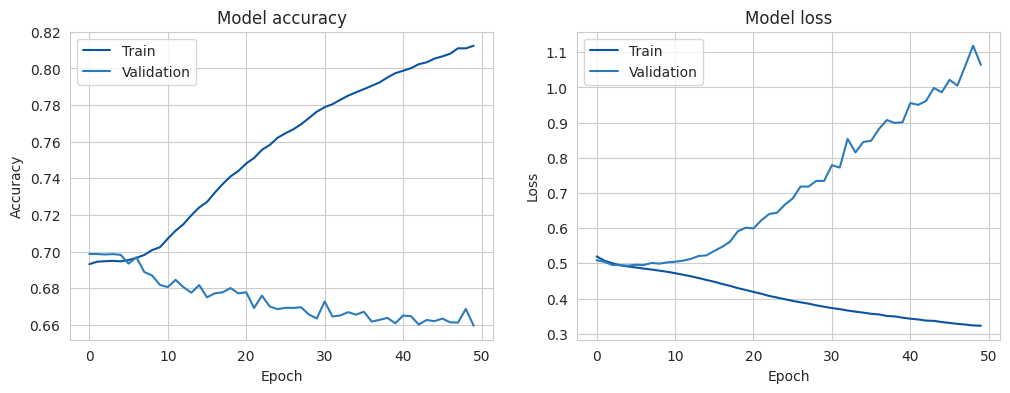

In [44]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


1223/1223 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Best Threshold=0.816935, G-Mean=0.673


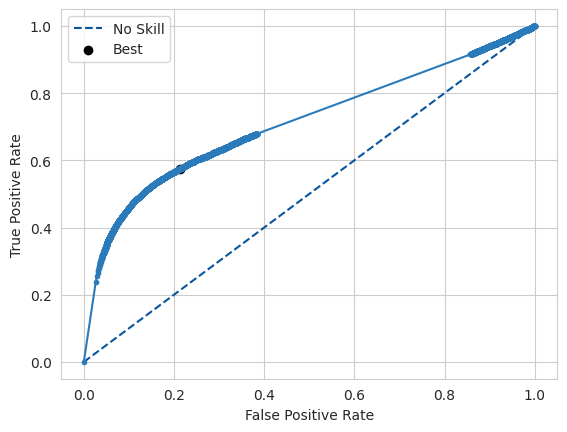

In [45]:
# predict probabilities
yhat = model.predict(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [46]:
y_pred_e=model.predict(X_test)
y_pred_e = (y_pred_e > thresholds[ix])

1223/1223 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [48]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='mako',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)


    if title:
        plt.title(title)

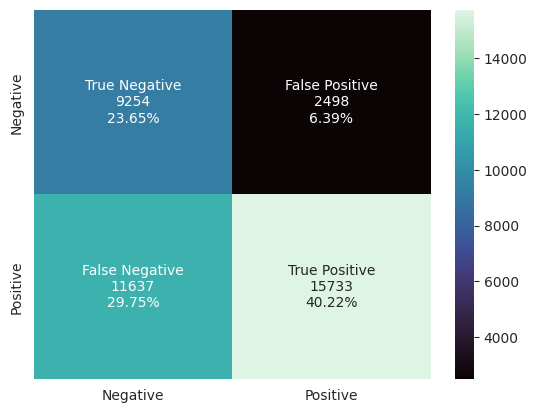

In [49]:
#Calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm9=confusion_matrix(y_test, y_pred_e)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Negative','Positive']
make_confusion_matrix(cm9,
                      group_names=labels,
                      categories=categories,
                      cmap='mako')

In [50]:
Confusion=metrics.classification_report(y_test,y_pred_e)
print(Confusion)

              precision    recall  f1-score   support

           0       0.44      0.79      0.57     11752
           1       0.86      0.57      0.69     27370

    accuracy                           0.64     39122
   macro avg       0.65      0.68      0.63     39122
weighted avg       0.74      0.64      0.65     39122

